# Preprocessing Notebook for Dataset 1


Before running this notebook, make sure to **create and activate** the conda environment defined by environment.yml using

```conda env create -f environment.yml```

```conda activate spam_classifier_env```

in the terminal.

IMPORTANT: Do not run cells twice as it can lead to unexpected errors.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [2]:
#NLTK download resources
nltk.download('stopwords') #for stopwords
nltk.download('punkt') #for tokenizer
nltk.download('wordnet') #for lemmatizer
nltk.download('averaged_perceptron_tagger') #for porter stemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/csuftitan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/csuftitan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/csuftitan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/csuftitan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
#Reading Data
data1 = pd.read_csv("../Datasets raw/dataset_1.csv") # ../ means navigating one up
data2 = pd.read_csv("../Datasets raw/dataset_2.csv") # ../ means navigating one up


#Preparing concatination of data1 and data2

#same column names
new_columns = {data2.columns[0]: data1.columns[1], data2.columns[1]: data1.columns[0]}
data2 = data2.rename(columns=new_columns)

#concat
data = pd.concat([data2, data1], axis=0, join="inner")

data.head()



,Message,Category
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


## General Cleaning techniques

In [4]:
#Resource used for this cell: https://medium.com/analytics-vidhya/text-preprocessing-for-nlp-natural-language-processing-beginners-to-master-fd82dfecf95

#Checking for missing values
data.dropna(inplace=True)


#COnverting Message Column to lower case
def to_lower(text):
    return str(text).lower()
data["Message"] = data["Message"].apply(to_lower)

#removing  possible https links 
def remove_urls(text):
    text = str(text)
    return re.sub(r'http\S+','',text)
data['Message'] = data['Message'].apply(remove_urls)



#removing special chars
def remove_special_chars(text):
    return re.sub('[^a-zA-Z]', ' ',text) #replace everything that is not a-z or A-Z with a blank space
data['Message'] = data['Message'].apply(remove_special_chars)


#tokenization
def tokenize(text):
    return word_tokenize(text)
data["Message"] = data["Message"].apply(tokenize) #IMPORTANT: This line converts each Mail (single string) into a list of strings


#removing stopwords
stopwords = stopwords.words('english') 
def remove_stopwords(token):
    return [item for item in token if item not in stopwords]
data["Message"] = data["Message"].apply(remove_stopwords)


#stemming IMPORTANT: Careful with this one! Has major effect on word outcome. Experiment and observe performance later on...
stemmer = PorterStemmer()
def clean_stem(token):
    return [stemmer.stem(i) for i in token]
data['Message'] = data['Message'].apply(clean_stem)



#lemmatization
lemma = WordNetLemmatizer()

def clean_lemma(token):
    return [lemma.lemmatize(word=w, pos="v") for w in token]

data["Message"] = data["Message"].apply(clean_lemma)


#removing words that consist of 1 or less letters
def remove_letters(token):
    return [i for i in token if len(i)>=2]

data['Message'] = data['Message'].apply(remove_letters)


def convert_to_string(token_list):
    return " ".join(token_list)

data['Message'] = data["Message"].apply(convert_to_string)

data.head(20)




,Message,Category
0,subject natur irresist corpor ident lt realli ...,1
1,subject stock trade gunsling fanni merril muzo...,1
2,subject unbeliev new home make easi im want sh...,1
3,subject color print special request addit info...,1
4,subject money get softwar cd softwar compat gr...,1
5,subject great nnew hello welcom medzonlin sh g...,1
6,subject hot play motion homeland secur invest ...,1
7,subject save money buy get thing tri ciall yet...,1
8,subject undeliver home base busi grownup messa...,1
9,subject save money buy get thing tri ciall yet...,1


## Dataset specific cleaning

In [5]:
#removing the word "subject" (necessary for data from dataset2)
data['Message'] = data['Message'].apply(lambda x: x.replace('subject ', ''))


#Converting "ham" and "spam" to 0s and 1s (necessary for data from dataset1)
def convert_label(labeltext):
    if(isinstance(labeltext,int)): return labeltext #this line covers the case that sb executes this cell twice where labeltext is an 0 or 1 already
    
    if(labeltext=='spam'): 
        return 1
    else:
        return 0    

data["Category"] = data["Category"].apply(convert_label)



In [6]:
#Write prepared results to csv file

data = data.dropna(subset=['Message']) #without this I get an error for missing values in training data in the next noebook

data.to_csv('data_cooked.csv', index=False)

## Data Exploration

([<matplotlib.axis.XTick at 0x7fbec9b61730>,
 [Text(0, 0, ''), Text(0, 0, '')])

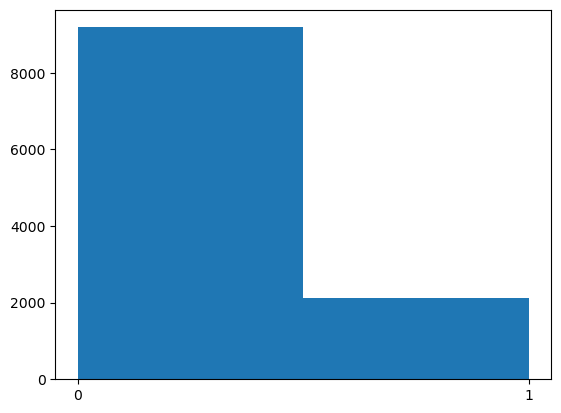

In [7]:
#Data has a lot more None Spam emails (0s) than spam emails (1s). Wonder if that is a problem...
plt.hist(data["Category"], bins=2)
plt.xticks([0,1])

#KEEP THIS IN MIND (data might need some resampling or so to get full performance)